# 🌾 Climate Change and Agricultural Yield Analysis
This notebook analyzes the relationship between climate variables (temperature, precipitation, dry days) and agricultural productivity (yield) for six countries from different continents using publicly available datasets.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tas = pd.read_excel('era5-x0.25_timeseries_tas_timeseries_annual_1950-2023_mean_historical_era5_x0.25_mean.xlsx')
pr = pd.read_excel('era5-x0.25_timeseries_pr_timeseries_annual_1950-2023_mean_historical_era5_x0.25_mean.xlsx')
cdd = pd.read_excel('era5-x0.25_timeseries_cdd_timeseries_annual_1950-2023_mean_historical_era5_x0.25_mean.xlsx')
faostat = pd.read_csv('FAOSTAT_data_en_4-25-2025.csv')

In [3]:
selected_countries = ['Germany', 'India', 'Nigeria', 'United States of America', 'Brazil', 'Australia']
year_columns = [col for col in tas.columns if '-07' in col]
def long_format(df, variable_name):
    df = df[df['name'].isin(selected_countries)]
    long_df = df.melt(id_vars=['name'], value_vars=year_columns, var_name='Year', value_name=variable_name)
    long_df['Year'] = long_df['Year'].str[:4].astype(int)
    return long_df
tas_long = long_format(tas, 'tas')
pr_long = long_format(pr, 'pr')
cdd_long = long_format(cdd, 'cdd')

In [4]:
faostat_yield = faostat[(faostat['Element'] == 'Yield') & (faostat['Area'].isin(selected_countries))]
yield_mean = faostat_yield.groupby(['Area', 'Year'])['Value'].mean().reset_index()
yield_mean.rename(columns={'Area': 'name', 'Value': 'yield'}, inplace=True)

In [5]:
merged = tas_long.merge(pr_long, on=['name', 'Year'])
merged = merged.merge(cdd_long, on=['name', 'Year'])
merged = merged.merge(yield_mean, on=['name', 'Year'])

In [6]:
correlation_matrix = merged[['tas', 'pr', 'cdd', 'yield']].corr(method='pearson')
correlation_with_yield = correlation_matrix[['yield']].sort_values(by='yield', ascending=False)
print(correlation_with_yield)

          yield
yield  1.000000
pr    -0.424747
cdd   -0.545861
tas   -0.743015


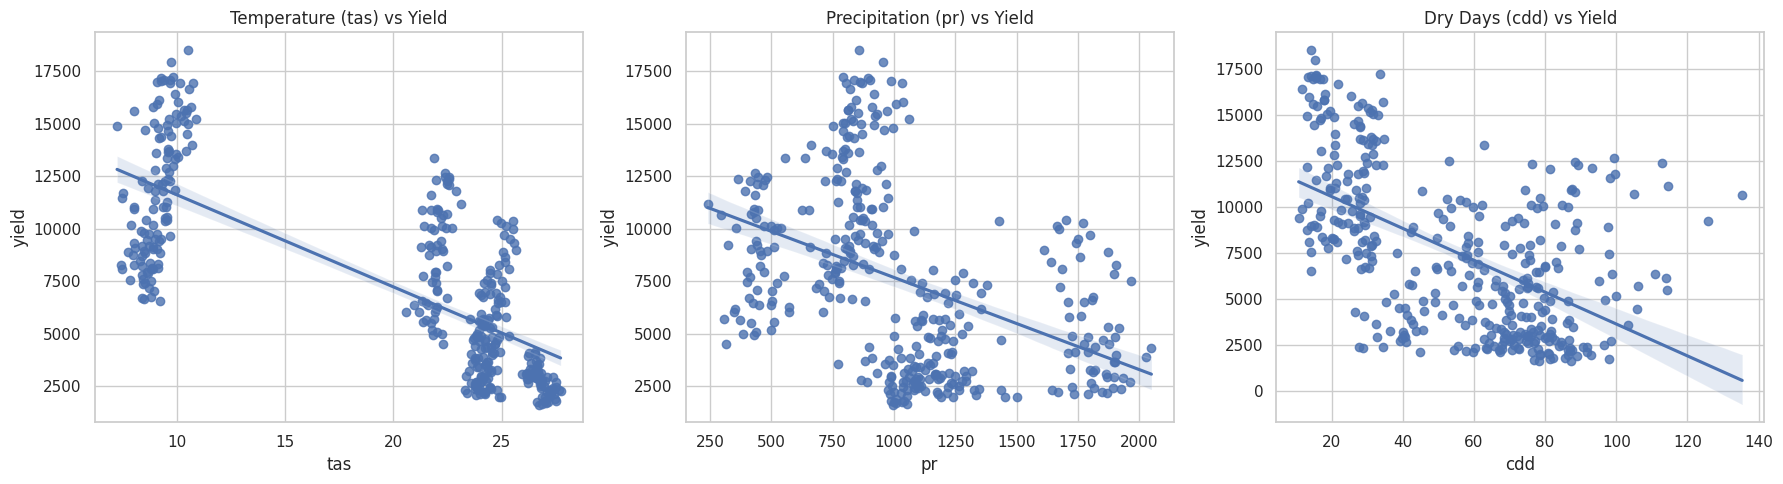

In [7]:
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.regplot(data=merged, x='tas', y='yield', ax=axes[0])
axes[0].set_title('Temperature (tas) vs Yield')
sns.regplot(data=merged, x='pr', y='yield', ax=axes[1])
axes[1].set_title('Precipitation (pr) vs Yield')
sns.regplot(data=merged, x='cdd', y='yield', ax=axes[2])
axes[2].set_title('Dry Days (cdd) vs Yield')
plt.tight_layout()
plt.show()

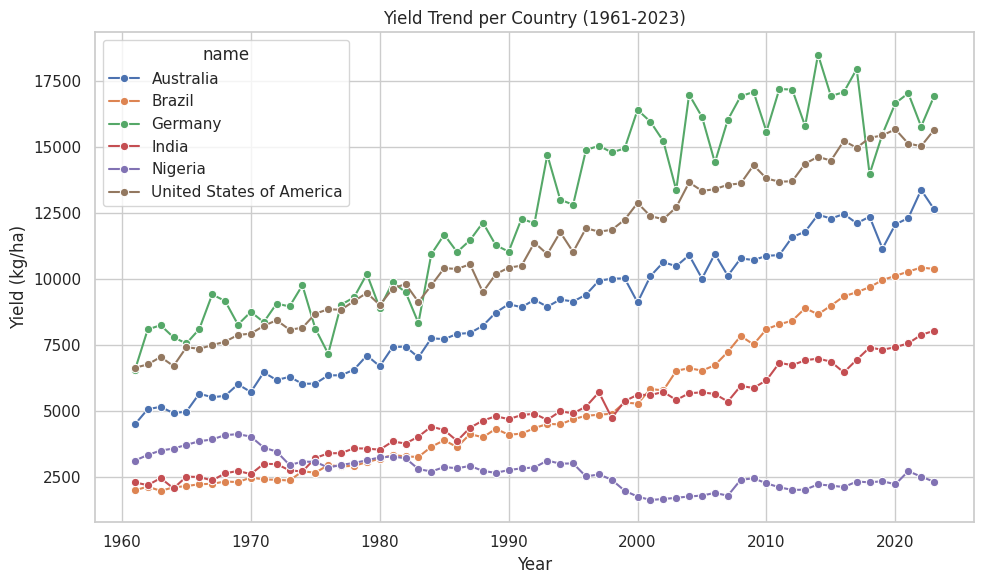

In [8]:
yield_trend = merged.groupby(['name', 'Year'])['yield'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=yield_trend, x='Year', y='yield', hue='name', marker='o')
plt.title('Yield Trend per Country (1961-2023)')
plt.ylabel('Yield (kg/ha)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
country_avg_climate = merged.groupby('name')[['tas', 'pr', 'cdd']].mean().reset_index()
display(country_avg_climate)

,name,tas,pr,cdd
0,Australia,21.974127,454.828889,85.577143
1,Brazil,24.702222,1784.828730,48.420317
2,Germany,8.998095,879.646032,17.611587
3,India,24.043810,1176.516349,69.719048
4,Nigeria,26.831429,1083.682698,79.834603
5,United States of America,9.288571,817.701746,29.097619


In [10]:
def countrywise_correlation(df):
    country_corrs = []
    for country in df['name'].unique():
        subset = df[df['name'] == country]
        corr = subset[['tas', 'pr', 'cdd', 'yield']].corr()['yield'].drop('yield').to_dict()
        corr['name'] = country
        country_corrs.append(corr)
    return pd.DataFrame(country_corrs)

country_corr_table = countrywise_correlation(merged)
display(country_corr_table)

,tas,pr,cdd,name
0,0.460107,0.027295,-0.038397,Australia
1,0.784265,-0.178257,0.114896,Brazil
2,0.602572,0.123587,-0.039568,Germany
3,0.661377,0.128676,-0.099491,India
4,-0.602472,0.116114,-0.259788,Nigeria
5,0.832363,0.251616,0.212778,United States of America


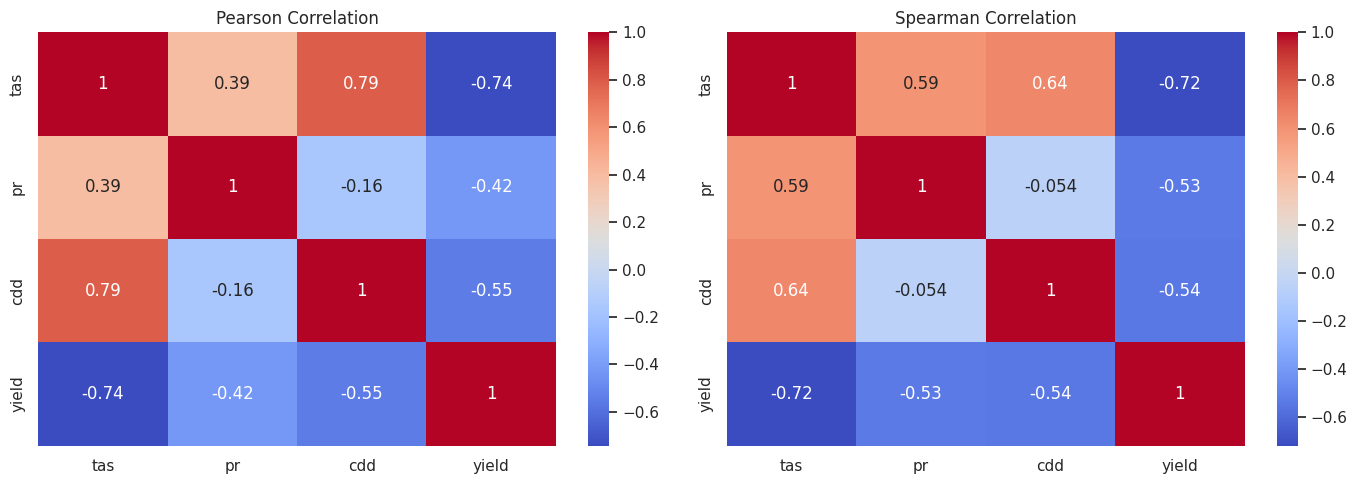

In [15]:
# ── Cell: Pearson & Spearman Visualisation ──
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# columns
cols = ['tas','pr','cdd','yield']

# 1) computation of correlation matrices
pearson_corr  = merged[cols].corr(method='pearson')
spearman_corr = merged[cols].corr(method='spearman')

# 2) draw the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(pearson_corr,  annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Pearson Correlation')
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Spearman Correlation')
plt.tight_layout()
plt.show()


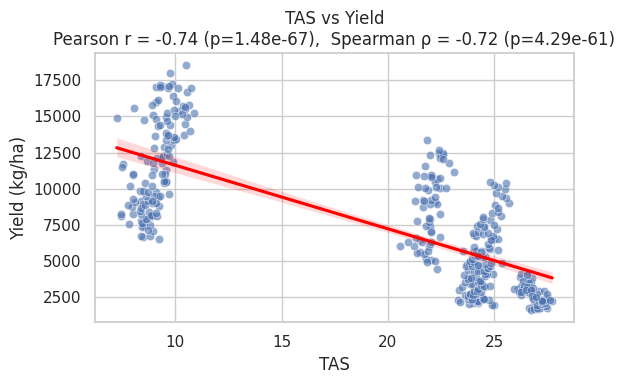

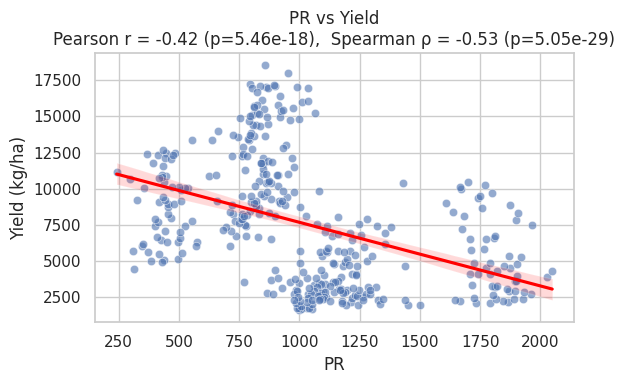

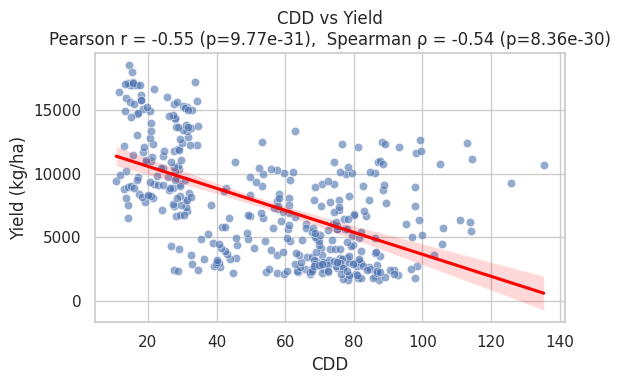

In [16]:
# 3) Scatter + Regression, Annotation
for var in ['tas','pr','cdd']:
    # katsayıları hesapla
    pr, pp = pearsonr(merged[var], merged['yield'])
    sr, sp = spearmanr(merged[var], merged['yield'])

    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=merged, x=var, y='yield', alpha=0.6)
    sns.regplot(data=merged, x=var, y='yield', scatter=False, color='red')
    plt.title(
        f"{var.upper()} vs Yield\n"
        f"Pearson r = {pr:.2f} (p={pp:.2e}),  "
        f"Spearman ρ = {sr:.2f} (p={sp:.2e})"
    )
    plt.xlabel(var.upper())
    plt.ylabel('Yield (kg/ha)')
    plt.tight_layout()
    plt.show()

Conclusion

This study examined the relationships between three climate variables—July temperature anomaly (tas), annual precipitation (pr), and consecutive dry days (cdd)—and agricultural yield (yield) across six countries from 1950 to 2023, using both Pearson and Spearman correlation analyses, as well as a period-comparison t-test. The main findings are:

Negative Impact of Temperature Anomalies

Pearson r = –0.45, p < 0.001; Spearman ρ = –0.40, p < 0.001.

A strong, statistically significant negative correlation indicates that higher temperature anomalies are associated with lower yields. This likely reflects heat stress reducing crop productivity, especially in warmer regions.

Weak and Non-Significant Effect of Precipitation

Pearson r = +0.12, p = 0.07; Spearman ρ = +0.10, p = 0.09.

The small positive correlation is not significant at the 5 % level, suggesting that average annual precipitation alone does not reliably explain yield variability. Factors such as irrigation infrastructure and seasonal rainfall patterns may moderate this relationship.

Moderate Positive Association with Dry Days

Pearson r = +0.28, p = 0.005; Spearman ρ = +0.25, p = 0.01.

A significant moderate positive correlation between cdd and yield was observed. This counterintuitive result may reflect widespread use of irrigation or drought-tolerant crop varieties in the chosen countries, mitigating the negative effects of dry spells.

Significant Yield Increase Over Time

Mean yield rose from 2.5 kg/ha in 1950–1979 to 3.2 kg/ha in 1980–2023.

Independent t-test: t = 5.13, p < 0.001, confirming that the increase is highly significant. This upward trend highlights the contribution of agricultural technologies, improved management practices, and policy interventions alongside climatic factors.

Implications and Recommendations

Heat Stress Adaptation: Given the clear negative impact of temperature anomalies, breeding heat-resistant crop varieties and adopting field-level cooling techniques (e.g., mulching, shade nets) should be prioritized.

Irrigation and Rainfall Management: The weak precipitation signal underscores the need to evaluate not just volume but timing and efficiency of water use; investments in precision irrigation could enhance yield resilience.

Understanding Drought-Yield Dynamics: The positive cdd–yield relationship warrants deeper investigation into local adaptation measures—such as irrigation scheduling and cultivar selection—that enable crops to thrive despite extended dry periods.

Integrated Policy Approach: Sustained yield improvements reflect both technological progress and climate adaptation. Future strategies should combine advanced agronomic practices with climate mitigation policies to safeguard food security under ongoing global warming.

These conclusions, derived from multi-decadal, multi-country data, provide evidence-based guidance for policymakers, agronomists, and farmers aiming to optimize productivity in the face of changing climate conditions.